In [129]:
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from skrebate import ReliefF
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor    

%matplotlib inline

In [130]:
data = pd.read_pickle('ALLDATA.pkl')
data=data.loc[-data['Wait Time (s)'].isin(['Err1','Err2','Err3','Err4','Err5'])]
data=data.loc[data['Age_9-12'].isin([0,1])]     #to make sure all data with google forms are selected

In [131]:
data = pd.read_pickle('ALLDATA.pkl')
data=data.loc[-data['Wait Time (s)'].isin(['Err1','Err2','Err3','Err4','Err5'])]
data=data.loc[data['Age_9-12'].isin([0,1])]


data=data.loc[:,['Wait Time (s)','Speed Limit', 'Lane Width', 'Minimum Gap', 'Mean Arrival Rate', 'AV', 
                   'Full Braking Before Impact_-1.0', 'Full Braking Before Impact_1', 
                   'Full Braking Before Impact_2', 'Full Braking Before Impact_3', 'Snowy',
                   'One way', 'two way', 'Two way with median', 'Night', 'numcars', 
                    'Age_9-12', 'Age_15-18', 'Age_12-15', 'Age_18 - 24', 'Age_25 - 29', 'Age_30 - 39', 'Age_40 - 49', 'Age_50 - 59', 'Age_60+', 'Gender_Female', 'Occupation_Employed', 'Occupation_Student', 'Occupation_Unemployed', 
                   'Occupation_kid', 'Education_Bachelors degree', 'Education_College/University student', 
                   'Education_Doctorate degree', 'Education_High school diploma', 'Education_Masters degree', 
                   'Education_Professional degree', 'driving license_Yes', 'mode_Bike', 'mode_Car',
                   'mode_Public Transit', 'mode_Walking', 'workwalk_No', 'workwalk_Sometimes', 'workwalk_Yes', 
                   'shopwalk_No', 'shopwalk_Sometimes', 'shopwalk_Yes', 'shopwalk_kid', 'Vrexp_Yes', 'Heart_Currently',
                   'Heart_Over the years', 'vision_Currently', 
                   'vision_Over the years', 'anxiety_Currently', 'anxiety_Over the years', 'Headaches_Currently',
                   'Headaches_Over the years', 'dizziness_Over the years']]         #numwalk and VRexpnum removed because of some false inputs in the data should be fixed later


data=data.apply(pd.to_numeric, errors='coerce')
def calculate_vif_(X, thresh=20.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

data=calculate_vif_(data, thresh=180.0)
data['E']=1   #all pedestrians cross, so no right censored data


/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


dropping 'Full Braking Before Impact_-1.0' at index: 6
dropping 'One way' at index: 10
dropping 'Age_9-12' at index: 14
dropping 'Age_18 - 24' at index: 16
dropping 'Occupation_Employed' at index: 22
dropping 'Occupation_kid' at index: 24
dropping 'Education_Bachelors degree' at index: 24
dropping 'mode_Bike' at index: 30
dropping 'workwalk_No' at index: 33
dropping 'shopwalk_Yes' at index: 37
Remaining variables:
Index(['Wait Time (s)', 'Speed Limit', 'Lane Width', 'Minimum Gap',
       'Mean Arrival Rate', 'AV', 'Full Braking Before Impact_1',
       'Full Braking Before Impact_2', 'Full Braking Before Impact_3', 'Snowy',
       'two way', 'Two way with median', 'Night', 'numcars', 'Age_15-18',
       'Age_12-15', 'Age_25 - 29', 'Age_30 - 39', 'Age_40 - 49', 'Age_50 - 59',
       'Age_60+', 'Gender_Female', 'Occupation_Student',
       'Occupation_Unemployed', 'Education_College/University student',
       'Education_Doctorate degree', 'Education_High school diploma',
       'Educati

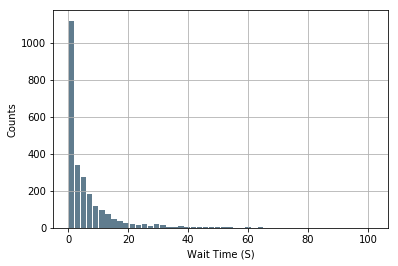

In [18]:
# Wait time freq table.
size, scale = 1000, 10
waittimes = pd.Series(data['Wait Time (s)'])

waittimes.plot.hist(grid=True, bins=50, rwidth=0.9,
                   color='#607c8e')
#plt.title('Waiting Time frequency distribution for all participants')
plt.xlabel('Wait Time (S)')
plt.ylabel('Counts')
plt.grid(axis='y', alpha=1)
plt.savefig('waitfreq.pdf')

In [132]:


#Find thresholds so that ~equal number of participants fall within each group
Thresholds=[.5,1.2,5,10]

In [133]:
data['w1']=0
data['w2']=0
data['w3']=0
data['w4']=0



In [134]:
data.loc[data['Wait Time (s)']<Thresholds[0],'w1']=1
data.loc[data['Wait Time (s)']<Thresholds[1],'w2']=1
data.loc[data['Wait Time (s)']<Thresholds[2],'w3']=1
data.loc[data['Wait Time (s)']<Thresholds[3],'w4']=1

In [135]:
features1, labels1 = data.drop(columns=['Wait Time (s)','w1','w2','w3','w4'], axis=1).values, data['w1'].values
features2, labels2 = data.drop(columns=['Wait Time (s)','w1','w2','w3','w4'], axis=1).values, data['w2'].values
features3, labels3 = data.drop(columns=['Wait Time (s)','w1','w2','w3','w4'], axis=1).values, data['w3'].values
features4, labels4 = data.drop(columns=['Wait Time (s)','w1','w2','w3','w4'], axis=1).values, data['w4'].values


In [136]:
ReliefWeights1=pd.DataFrame(index=range(features1.shape[1]),columns=['Covariate','Importance'])
fs1 = ReliefF()
fs1.fit(features1, labels1)
i=0
for feature_name, feature_score in zip(data.drop(columns=['Wait Time (s)','w1','w2','w3','w4'],axis=1).columns,
                                       fs1.feature_importances_):
    ReliefWeights1.iloc[i,0] = feature_name
    ReliefWeights1.iloc[i,1]= feature_score
    i=i+1

In [137]:
ReliefWeights2=pd.DataFrame(index=range(features2.shape[1]),columns=['Covariate','Importance'])
fs2 = ReliefF()
fs2.fit(features2, labels2)
i=0
for feature_name, feature_score in zip(data.drop(columns=['Wait Time (s)','w1','w2','w3','w4'],axis=1).columns,
                                       fs2.feature_importances_):
    ReliefWeights2.iloc[i,0] = feature_name
    ReliefWeights2.iloc[i,1]= feature_score
    i=i+1

In [138]:
ReliefWeights3=pd.DataFrame(index=range(features3.shape[1]),columns=['Covariate','Importance'])
fs3 = ReliefF()
fs3.fit(features3, labels3)
i=0
for feature_name, feature_score in zip(data.drop(columns=['Wait Time (s)','w1','w2','w3','w4'],axis=1).columns,
                                       fs3.feature_importances_):
    ReliefWeights3.iloc[i,0] = feature_name
    ReliefWeights3.iloc[i,1]= feature_score
    i=i+1

In [139]:
ReliefWeights4=pd.DataFrame(index=range(features4.shape[1]),columns=['Covariate','Importance'])
fs4 = ReliefF()
fs4.fit(features4, labels4)
i=0
for feature_name, feature_score in zip(data.drop(columns=['Wait Time (s)','w1','w2','w3','w4'],axis=1).columns,
                                       fs4.feature_importances_):
    ReliefWeights4.iloc[i,0] = feature_name
    ReliefWeights4.iloc[i,1]= feature_score
    i=i+1

In [140]:
ReliefAvg=pd.DataFrame(index=range(features3.shape[1]),columns=['Covariate','Importance'])
ReliefAvg['Covariate']=ReliefWeights1['Covariate']
ReliefAvg['Importance']=(ReliefWeights1['Importance']+ReliefWeights2['Importance']
                        +ReliefWeights3['Importance']+ReliefWeights4['Importance'])/4

In [141]:
ReliefAvg.to_pickle('ReliefAvg.pkl')      #save ReliefAvg

In [142]:
ReliefAvg.sort_values(['Importance'],ascending=False)

,Covariate,Importance
12,numcars,0.0708689
3,Mean Arrival Rate,0.0562282
16,Age_30 - 39,0.0543829
2,Minimum Gap,0.0537505
20,Gender_Female,0.0492174
30,mode_Public Transit,0.0451847
26,Education_Masters degree,0.043718
34,shopwalk_No,0.0405806
21,Occupation_Student,0.0396985
37,Vrexp_Yes,0.0388317


In [ ]:
data[ReliefAvg.sort_values(['Importance'],ascending=False)['Covariate'][:10].values.append('Wait Time (s)')]

In [111]:
data[ReliefAvg.sort_values(['Importance'],ascending=False)['Covariate'][:10].values,'Wait Time (s)']

NameError: name 'ReliefAvg' is not defined